# FastText and FastText pre-train

In [21]:
import pandas as pd
from underthesea import word_tokenize, text_normalize

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV

# Data Preprocessing

In [60]:
df = pd.read_csv('facebook_comment_2k7.csv')
df.head()

,Unnamed: 0,id,text,label
0,0,3113b477-4ea3-4c3f-82d7-6ae6b8c12a3b,Noi cho biet k rãnh viet voi loai ng nhu chị c...,['harassment']
1,1,de5cf256-3879-413d-9e33-2c3be7e2e0c1,-Giải ngân cực nhanh\n-mức vay lên đến 15tr\n👉...,['dangerous_content']
2,2,975a369c-acc2-487c-84dd-64a4764203cf,Thủ tục đơn giản đăng ký khoản vay giải ngân l...,['dangerous_content']
3,3,45aa9b39-c58a-4c91-941a-fe6373d009f5,săn mãi con đen v5 cả tối k đc an ủi đc con be...,['normal']
4,4,99f6d7e6-b1c0-4849-9430-c60137737ead,zalo 0375841653 ae nào mua kết bạn zalo đặt hà...,['dangerous_content']


In [61]:
df = df.drop(['Unnamed: 0', 'id'], axis=1)
df.head()

,text,label
0,Noi cho biet k rãnh viet voi loai ng nhu chị c...,['harassment']
1,-Giải ngân cực nhanh\n-mức vay lên đến 15tr\n👉...,['dangerous_content']
2,Thủ tục đơn giản đăng ký khoản vay giải ngân l...,['dangerous_content']
3,săn mãi con đen v5 cả tối k đc an ủi đc con be...,['normal']
4,zalo 0375841653 ae nào mua kết bạn zalo đặt hà...,['dangerous_content']


In [4]:
print(df.shape)

(2700, 2)


Đối với những sample có 2 label trở lên thì tách thành các sample riêng chỉ với 1 label

In [62]:
import ast

df['label'] = df['label'].apply(ast.literal_eval) # convert string to list
df  = df.explode('label')
df.head()

,text,label
0,Noi cho biet k rãnh viet voi loai ng nhu chị c...,harassment
1,-Giải ngân cực nhanh\n-mức vay lên đến 15tr\n👉...,dangerous_content
2,Thủ tục đơn giản đăng ký khoản vay giải ngân l...,dangerous_content
3,săn mãi con đen v5 cả tối k đc an ủi đc con be...,normal
4,zalo 0375841653 ae nào mua kết bạn zalo đặt hà...,dangerous_content


In [63]:
print(df.shape)

(2790, 2)


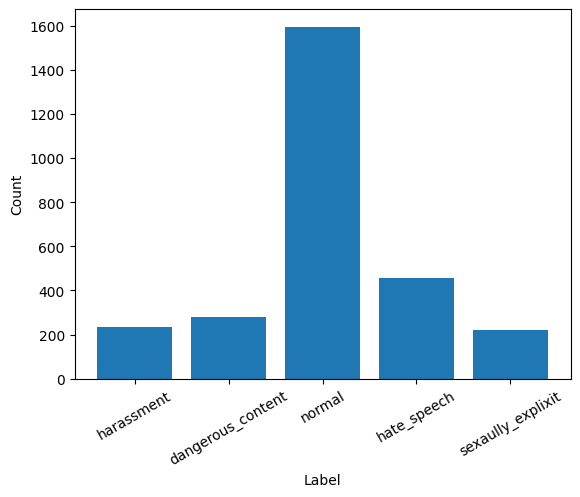

In [64]:
from collections import Counter
from matplotlib import pyplot as plt

label_count = Counter(df['label'])
plt.bar(label_count.keys(), label_count.values())
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(rotation=30)
plt.show()

In [65]:
print(label_count)

Counter({'normal': 1595, 'hate_speech': 456, 'dangerous_content': 281, 'harassment': 236, 'sexaully_explixit': 222})


In [67]:
import re
def clean_text(text):
    text = re.sub('<.*?>', '', text).strip()
    text = re.sub('(\s)+', r'\1', text)
    return text

def preprocess_text(text):
    text = text_normalize(clean_text(text))
    return text
    
df['text'] = df['text'].apply(preprocess_text)

df.head()

,text,label
0,Noi cho biet k rãnh viet voi loai ng nhu chị c...,harassment
1,- Giải ngân cực nhanh - mức vay lên đến 15 tr ...,dangerous_content
2,Thủ tục đơn giản đăng ký khoản vay giải ngân l...,dangerous_content
3,săn mãi con đen v5 cả tối k đc an ủi đc con be...,normal
4,zalo 0375841653 ae nào mua kết bạn zalo đặt hà...,dangerous_content


In [68]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df['text'], df['label'], test_size=0.2, random_state=42)

In [16]:
from gensim.models.fasttext import load_facebook_vectors

fastText = load_facebook_vectors('cc.vi.300.bin')

maps sentences & paragraphs to a 300 dimensional dense vector space

In [69]:
import numpy as np

def get_sentence_vector(sentence):
    words = word_tokenize(sentence)
    vector = [fastText[word] for word in words if word in fastText] # find word vector of each word using the fastText model

    if len(vector) == 0:
        return np.zeros(300) # if no word in the sentence is in the fastText model, return a vector of zeros

    return np.mean(vector, axis=0) # produces a single vector representation for the entire sentence instead of individual vectors for each word

X_train = X_train.apply(get_sentence_vector)
X_test = X_test.apply(get_sentence_vector)

In [71]:
test_sentence = "Hôm nay tôi đi học"
print(word_tokenize(test_sentence))
test_embedding = get_sentence_vector(test_sentence)
print(test_embedding)
print(len(test_embedding))

['Hôm nay', 'tôi', 'đi', 'học']
[-0.03998459 -0.09024322  0.03998923 -0.01129382 -0.01020592 -0.05625008
 -0.01545474  0.01107461  0.02221097  0.01259642 -0.01535177 -0.01670004
  0.04531933  0.02423507 -0.02802736  0.00181671  0.01901957  0.01778849
  0.0334981   0.06092557  0.04605487 -0.0851677   0.03711953  0.03870582
  0.01576734  0.01439876  0.03745887  0.01776986  0.101591   -0.028581
 -0.09844563 -0.04842743  0.00315917 -0.00767461  0.0769645   0.04250296
  0.07927462  0.03776968  0.01553182  0.01373811  0.01805595 -0.03451899
  0.06367618  0.00381823  0.00367786  0.03406303  0.02472002  0.01171674
  0.10197307 -0.05773519 -0.00813258 -0.11804187  0.03836709  0.02259393
  0.02605221 -0.05120831 -0.02605844  0.00776526 -0.04185459 -0.0444543
  0.08806551  0.04306923  0.03916912 -0.06692795 -0.03056506 -0.00039773
 -0.01790737 -0.01539941  0.04859369  0.13536358  0.03922917  0.04090336
  0.00629604 -0.07639884 -0.07999296  0.01021366 -0.00287843 -0.03049158
  0.02599778  0.029127

In [72]:
# stack the individual sentence vector into a single array.
X_train = np.stack(X_train)
X_test = np.stack(X_test)

In [73]:
print("X_train shape:", X_train.shape)

X_train shape: (2232, 300)


Tìm model tốt nhất với các param

In [74]:
# Define the parameter grids for each model
param_grid_lr = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga']
}

param_grid_dt = {
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

param_grid_svc = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}

# Define the dictionary of models with their corresponding parameter grids
models = {
    "Logistic Regression": (LogisticRegression(), param_grid_lr),
    "Decision Tree Classifier": (DecisionTreeClassifier(), param_grid_dt),
    "Random Forest Classifier": (RandomForestClassifier(), param_grid_rf),
    "SVC": (SVC(), param_grid_svc)
}

# Perform GridSearchCV for each model
best_models = {}
for model_name, (model, param_grid) in models.items():
    grid_search = GridSearchCV(model, param_grid, cv=5, n_jobs=-1)
    grid_search.fit(X_train, y_train)
    best_models[model_name] = grid_search.best_estimator_

c:\Users\thanh\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [75]:
print(best_models)

{'Logistic Regression': LogisticRegression(C=10, solver='saga'), 'Decision Tree Classifier': DecisionTreeClassifier(max_depth=10, min_samples_split=10), 'Random Forest Classifier': RandomForestClassifier(max_depth=20, min_samples_leaf=2, min_samples_split=5,
                       n_estimators=50), 'SVC': SVC(C=1)}


In [76]:
for name, model in best_models.items():
    # model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"Model: {name}")
    print(classification_report(y_test, y_pred))

Model: Logistic Regression
                   precision    recall  f1-score   support

dangerous_content       0.91      0.73      0.81        59
       harassment       0.47      0.13      0.21        52
      hate_speech       0.58      0.65      0.61        83
           normal       0.81      0.94      0.87       325
sexaully_explixit       0.73      0.49      0.58        39

         accuracy                           0.77       558
        macro avg       0.70      0.59      0.62       558
     weighted avg       0.75      0.77      0.75       558

Model: Decision Tree Classifier
                   precision    recall  f1-score   support

dangerous_content       0.59      0.61      0.60        59
       harassment       0.17      0.12      0.14        52
      hate_speech       0.33      0.33      0.33        83
           normal       0.73      0.78      0.76       325
sexaully_explixit       0.30      0.26      0.28        39

         accuracy                           0.60   

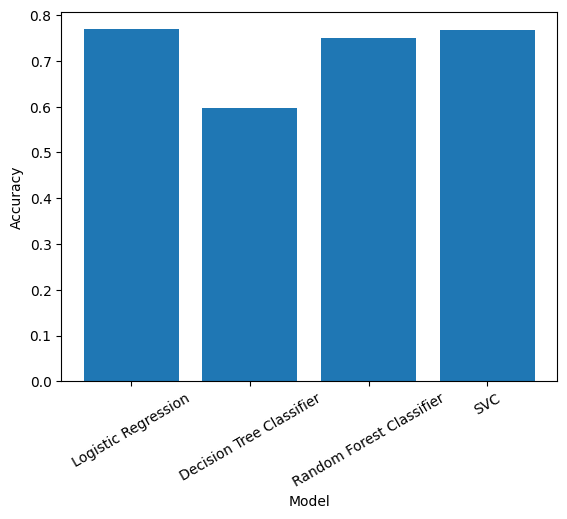

In [77]:
from matplotlib import pyplot as plt

models_accuracy = {name: model.score(X_test, y_test) for name, model in best_models.items()}
plt.bar(models_accuracy.keys(), models_accuracy.values())
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.xticks(rotation=30)
plt.show()

Modal default không set các param

In [78]:
models = {
    "Logistic Regression": LogisticRegression(),
    "Decision Tree Classifier": DecisionTreeClassifier(),
    "Random Forest Classifier": RandomForestClassifier(),
    "SVC": SVC()
}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"Model: {name}")
    print(classification_report(y_test, y_pred))

Model: Logistic Regression
                   precision    recall  f1-score   support

dangerous_content       0.97      0.59      0.74        59
       harassment       1.00      0.06      0.11        52
      hate_speech       0.56      0.57      0.56        83
           normal       0.74      0.98      0.84       325
sexaully_explixit       0.67      0.10      0.18        39

         accuracy                           0.73       558
        macro avg       0.79      0.46      0.49       558
     weighted avg       0.76      0.73      0.67       558

Model: Decision Tree Classifier
                   precision    recall  f1-score   support

dangerous_content       0.68      0.66      0.67        59
       harassment       0.25      0.29      0.27        52
      hate_speech       0.34      0.34      0.34        83
           normal       0.78      0.74      0.76       325
sexaully_explixit       0.23      0.31      0.26        39

         accuracy                           0.60   

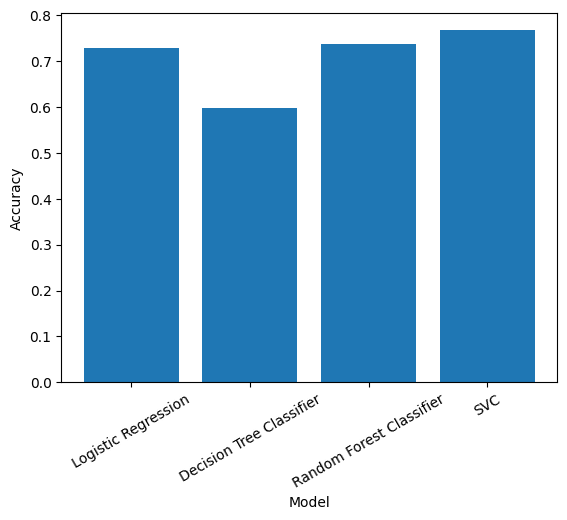

In [79]:
from matplotlib import pyplot as plt

models_accuracy = {name: model.score(X_test, y_test) for name, model in models.items()}
plt.bar(models_accuracy.keys(), models_accuracy.values())
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.xticks(rotation=30)
plt.show()